# Imports

In [1]:
PROJECT_DIR = "/Users/pluz999/Documents/Oxford/Thesis/queue-value"

import sys
sys.path.append(PROJECT_DIR)

from datetime import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from micro_price.StoikovMicroPrice import StoikovMicroPrice
from orderbook_aggregator.StoikovAggregator import StoikovAggregator

# Global variables

In [2]:
ticker = "JNJ"
levels = 3
start_date = datetime(2018,6,4)
end_date = datetime(2018,6,29)

# Load and process order book data

In [3]:
stoikov_microprice = StoikovMicroPrice([])
for date in tqdm(pd.date_range(start_date, end_date)):
    try:
        stoikov_orderbook = StoikovAggregator(date, ticker, levels, max_spread=400)
        stoikov_microprice.build_from_orderbooks([stoikov_orderbook])
    except FileNotFoundError:
        continue

100%|██████████| 26/26 [02:47<00:00,  6.45s/it]


# Order book analysis

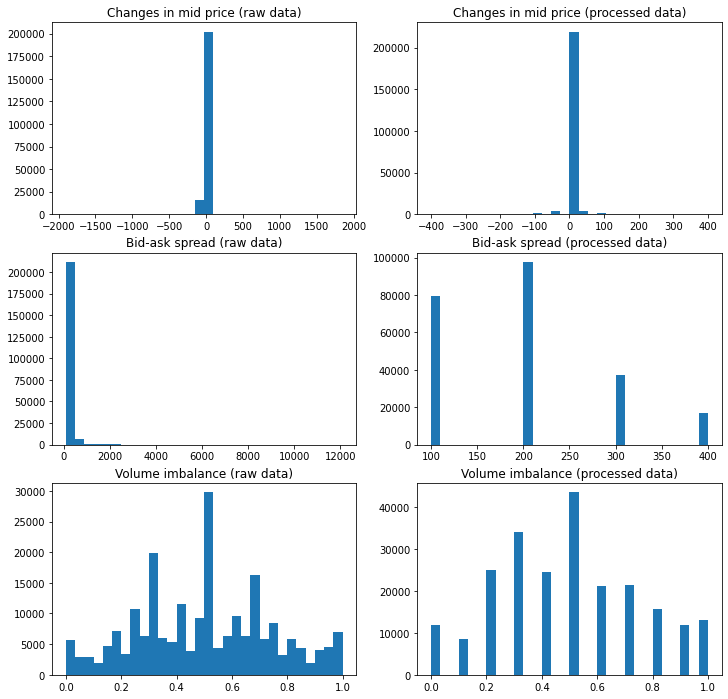

In [4]:
fig, ax = plt.subplots(3,2, figsize=(12,12))

ax[0,0].hist(stoikov_orderbook.raw_orderbook["mid_price_move"], bins=30)
ax[0,0].set_title("Changes in mid price (raw data)")

ax[0,1].hist(stoikov_orderbook.orderbook["mid_price_move"], bins=30)
ax[0,1].set_title("Changes in mid price (processed data)")

ax[1,0].hist(stoikov_orderbook.raw_orderbook["spread"], bins=30)
ax[1,0].set_title("Bid-ask spread (raw data)")

ax[1,1].hist(stoikov_orderbook.orderbook["spread"], bins=30)
ax[1,1].set_title("Bid-ask spread (processed data)")

ax[2,0].hist(stoikov_orderbook.raw_orderbook["imbalance"], bins=30)
ax[2,0].set_title("Volume imbalance (raw data)")

ax[2,1].hist(stoikov_orderbook.orderbook["imbalance"], bins=30)
ax[2,1].set_title("Volume imbalance (processed data)")

plt.show()

# Calculate micro-price

In [5]:
micro_price = stoikov_microprice.calculate_micro_price()

# Plot micro-price

In [6]:
example_plot = stoikov_orderbook.orderbook.iloc[14000:17000].copy()
example_micro_prices = [
    micro_price.loc[imbalance, spread] 
    for imbalance, spread in zip(example_plot["imbalance"], example_plot["spread"])
]
example_plot["micro_price"] = example_micro_prices

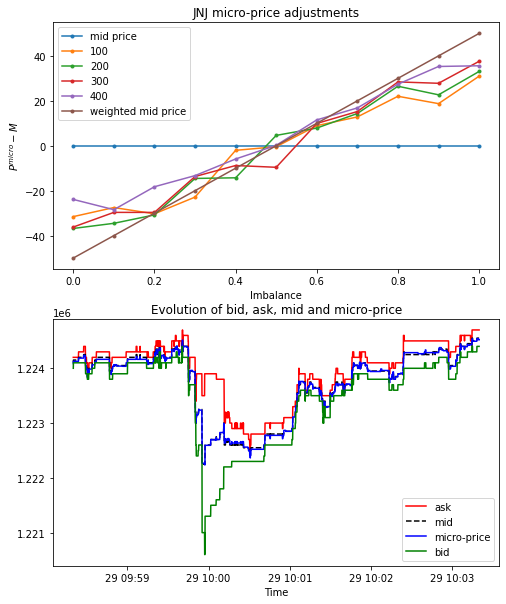

In [7]:
fig, ax = plt.subplots(2, figsize=(8,10))

ax[0].plot(micro_price.index, np.repeat(0,len(micro_price.index)), ".-")
ax[0].plot(micro_price, ".-")
ax[0].plot(micro_price.index, np.linspace(-50,50,len(micro_price.index)), ".-")
ax[0].set_xlabel("Imbalance")
ax[0].set_ylabel("$P^{micro} - M$")
ax[0].set_title("JNJ micro-price adjustments")
ax[0].legend(["mid price"] + list(micro_price.columns) + ["weighted mid price"], loc="upper left")

ax[1].plot(example_plot["ask_price_0"], "r")
ax[1].plot(example_plot["mid_price"], "k--")
ax[1].plot(example_plot["mid_price"] + example_plot["micro_price"], "b")
ax[1].plot(example_plot["bid_price_0"], "g")
ax[1].set_title("Evolution of bid, ask, mid and micro-price")
ax[1].set_xlabel("Time")
ax[1].legend(["ask", "mid", "micro-price", "bid"], loc="lower right")

plt.show()